Running WaveStats Algorithm:
Extracting data from file...


NameError: name 'acc_fil' is not defined

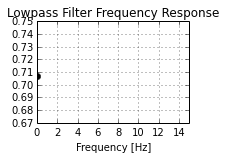

In [3]:
#Purisa Jasmine Simmons
#Friday July 13, 2018
#Algorithm to filter acceleration data, using low-pass Butterworth filter,
#before calculating displacements.

%matplotlib inline

from scipy import signal
import math
import re

import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 0.0  # desired cutoff frequency of the filter, Hz --- need to figure this out**




#^^^^^^^^^^^^






# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 2, 3)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()




#Need to do peak-picking before algorithm runs:
#1. Read through file, save all times and accelerations:
print('Running WaveStats Algorithm:')

#Reading data from filename_r
filename_r = "Motion_14637.CSV"
read_file = open(filename_r, "r")

#Initialize lists
t1 = 0 
t2 = 0
time_e_list = []  #list of ***elapsed*** times
time_o_list = []  #list of ***offset*** times
acc_list = []     #list of estimated accelerations
disp_list = []    #list of estimated displacements
disp_list_f = []    #list of estimated displacements


print 'Extracting data from file...'
with open(filename_r, 'r') as f: 
  for line in f:
    str_array = line.split(',')  #separates each line into an array on commas

    #-------Calculating Time Offset--------#
    if str_array[0] == "UTC":
      t1 = 0
      t2 = 0
      time_e_list.append(0)
      time_o_list.append(0)

    else:
      t2 = str_array[0]

      if (t2 != 0 and t1 != 0 and str_array[2] != "N/A"):
        time_regex = r"(\.\d+)"
        t2_val = float(re.search(time_regex, t2).group(1))
        t1_val = float(re.search(time_regex, t1).group(1))

        #print t2_val
        #print t1_val

        t_out = t2_val - t1_val #measured in secs

        #t_out is the time offset between two subsequent samples
        if (t_out < 0): 
          t_out = t_out + 1

        #print ("Printing time_offsets")
     
        last = len(time_e_list) - 1
        last_time = time_e_list[last] 
        new_time = t_out + last_time  #new_time is the total elapsed time

        time_e_list.append(new_time)
        time_o_list.append(t_out)

      if (str_array[2] != "N/A" and str_array[3] != "N/A" and \
        str_array[4] != "N/A" and str_array[2] != "IMU A1"):

        g_const = 512     #g_const is scaling constant: 500 (500raw units = 1g)
        gravity = -9.80665 #gravity is the constant 9.80665m^2/s 

        ax = int(str_array[2])  #x-axis (horizontal direction 1)
        #ax = (ax/g_const)*gravity
        ay = int(str_array[3])  #y-axis, affected by gravity (vertical)
        #ay = (ay/g_const)*gravity
        az = int(str_array[4])  #z-axis (horizontal direction 2)
        #az = (az/g_const)*gravity


        #Calculate the magnitude of acceleration from all three axes:
        a_mag = math.sqrt(ax**2 + ay**2 + az**2)

        #Double integrate aA to get approximate distance b/w wave trough and crest
        #aA = a_mag - gravity     #aA is the approximated vertical acceleration
        aA = (a_mag/g_const)*gravity - gravity

    
        #print aA

        acc_list.append(aA)


    #Reset t1 and t2 after t_out is calculated
    t1 = t2
    t2 = 0

#----------Here, after both lists created, now filter acceleration data----------
time_array = np.array(time_e_list)
acc_array = np.array(acc_list)


#-------Generating non-filtered displacement data here:
len1 = len(time_e_list)
len2 = len(time_o_list)
len3 = len(acc_list)

if (len1 != len2 or len1 != len3):
  print("Error: Lengths of lists do not match!")
  print(len1)
  print(len2)
  print(len3)

else:
  #Initializations
  a0 = 0
  v0 = 0
  d0 = 0
  i = 0

  disp_list.append(0)

  #Calculations
  while (i < len1 - 1):
    t = time_o_list[i]
    a_new = acc_list[i]
    v_new = a_new*t + v0
    d_new = (0.5*a_new*(t**2)) + v_new*t + d0

    #print(d_new)

    last_di = len(disp_list) - 1      #index of last element in disp_list
    last_d = disp_list[last_di]       #last elem from disp_list
    total_d = d_new + last_d
    disp_list.append(total_d)

    #print(total_d)

    i = i + 1


len4 = len(disp_list)
if (len1 != len4):
  print("Error: Lengths of disp_list doesn't match!")
  print("Length of disp_list is: %d while len of acc_list is: %d")%(len(disp_list), len(acc_list))

#-------Now filtering acceleration data:



## Demonstrate the use of the filter.
## First make some data to be filtered.
#T = 5.0         # seconds
#n = int(T * fs) # total number of samples
#t = np.linspace(0, T, n, endpoint=False)
## "Noisy" data.  We want to recover the 1.2 Hz signal from this.
#data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)

## Filter the data, and plot both the original and filtered signals.
#y = butter_lowpass_filter(data, cutoff, fs, order)

#plt.subplot(2, 1, 2)
#plt.plot(t, data, 'b-', label='data')
#plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
#plt.xlabel('Time [sec]')
#plt.grid()
#plt.legend()

#plt.subplots_adjust(hspace=0.35)
#plt.show()












#-------------------Here, after filtering---------------
len1 = len(time_e_list)
len2 = len(time_o_list)
len3 = len(acc_fil)

if (len1 != len2 or len1 != len3):
  print("Error: Lengths of lists do not match!")
  print(len1)
  print(len2)
  print(len3)

else:
  #Initializations
  a0 = 0
  v0 = 0
  d0 = 0
  i = 0

  disp_list_f.append(0)

  #Calculations
  while (i < len1 - 1):
    t = time_o_list[i]
    a_new = acc_fil[i]
    v_new = a_new*t + v0
    d_new = (0.5*a_new*(t**2)) + v_new*t + d0

    #print(d_new)

    last_di = len(disp_list_f) - 1      #index of last element in disp_list
    last_d = disp_list_f[last_di]       #last elem from disp_list
    total_d = d_new + last_d
    disp_list_f.append(total_d)

    #print(total_d)

    i = i + 1


len4 = len(disp_list_f)
if (len1 != len4):
  print("Error: Lengths of disp_list doesn't match!")
  print("Length of disp_list is: %d while len of acc_list is: %d")%(len(disp_list), len(acc_list))

#--------Here, after calculations, ready to graph---------

disp_array = np.array(disp_list)
disp_array_f = np.array(disp_list_f)
acc_fil_array = np.array(acc_fil)

plt.subplot(2, 2, 1)
plt.plot(time_array, acc_array)
plt.title('Non-filtered acceleration')
plt.ylabel('Acceleration [m/s^2]')
plt.xlabel('Time [s]')

plt.subplot(2, 2, 2)
plt.plot(time_array, disp_array)
plt.title('Non-filtered displacement')
plt.ylabel('Acceleration [m/s^2]')
plt.xlabel('Time [s]')

plt.subplot(2, 2, 3)
plt.plot(time_array, acc_fil_array)
plt.title('Filtered acceleration using Butter filter')
plt.ylabel('Acceleration [m/s^2]')
plt.xlabel('Time [s]')
         
plt.subplot(2, 2, 4)
plt.plot(time_array, disp_array_f)
plt.title('Displacement from filtered acceleration using Butter filter')
plt.ylabel('Displacement [m]')
plt.xlabel('Time [s]')


#plt.tight_layout()

plt.subplots_adjust(left=0.001, bottom=0.1, right=1.0, top=0.9,
                wspace=1.0, hspace=1.0)

plt.show()